In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import hillmaker as hm

# Choosing the date range for analysis

You need to be careful when specifying the start and end dates for your analysis (we call this the *analysis range*) and to consider *horizon and warmup effects*. In the SSU example, each stop is just a few hours and there aren't any patients who arrive before 2024-01-01 and are still in the SSU on 2024-01-01. However, if we were working with data in which the stops are a few days in length (such as on an inpatient nursing unit), we need to think about what start date and end date we should use and exactly how the original dataset was extracted. Hillmaker is completely capable of properly accounting for patients who arrive before the specified start date for the analysis as well as those who are discharged after the end date. However, it can only work with the stop data provided. 

## The easy case - No midnight overlap

If the system you are analyzing starts and ends empty each day, then you can set your analysis date range to any range that is contained by date range of your data. You just need to be careful that you don't specify a `start_analysis_dt` or `end_analysis_dt` that is outside the date range of your stop records. There is a data validation check done that will flag such values and raise an error. For example, if we accidentally specify the wrong year on the start date, this happens:

In [6]:
!hillmaker --scenario example1 --data ./data/ssu_2024.csv \
--in_field InRoomTS --out_field OutRoomTS --cat_field PatType --bin_size_minutes 60 \
--start_analysis_dt 2023-01-02 --end_analysis_dt 2024-09-30 --csv_export_path output --plot_export_path output --ylabel Patients 

Traceback (most recent call last):
  File "/home/mark/anaconda3/envs/hm_oo/bin/hillmaker", line 33, in <module>
    sys.exit(load_entry_point('hillmaker', 'console_scripts', 'hillmaker')())
  File "/home/mark/Documents/projects/hillmaker/src/hillmaker/console.py", line 347, in main
    scenario = create_scenario(params_dict=args_dict)
  File "/home/mark/Documents/projects/hillmaker/src/hillmaker/scenario.py", line 710, in create_scenario
    scenario = Scenario(**params)
  File "/home/mark/anaconda3/envs/hm_oo/lib/python3.10/site-packages/pydantic/main.py", line 159, in __init__
    __pydantic_self__.__pydantic_validator__.validate_python(data, self_instance=__pydantic_self__)
pydantic_core._pydantic_core.ValidationError: 1 validation error for Scenario
  Value error, start analysis date of 2023-01-02T00:00:00.000000000 is > 48 hours before earliest arrival of 2024-01-01 07:44:00 [type=value_error, input_value={'scenario_name': 'exampl...rt_summaries_csv': True}, input_type=dict]
    F

## The relatively easy case - Short length of stays with limited midnight overlap

If you have relatively short lengths of stay (up to several hours) such as in the SSU example, you just need to make sure that your specify an analysis range that is fully contained within the date range for the stop data records you are using. If our data contains all patients **discharged** between 2024-01-01 and 2024-09-30, we can safely use an analysis date range of `start_analysis_dt = 2024-01-01` and `end_analysis_dt = 2024-09-29`. We might be even able to use an end date of 2024-09-30 if we are not concerned about patients who arrived on or before 2024-09-30 but were discharged after this date. 

Even better, if when pulling the original data we made sure to grab all patient records for those patients who were discharged on or after 2024-01-01 and who arrived on or before 2024-09-30, then we could use `start_analysis_dt = 2024-01-01` and `end_analysis_dt = 2024-09-30`. If you do this, even long lengths of stay do not impact the analysis as hillmaker will account for all records in which any part of the stay overlaps the analysis date range.

With a large number of records and multi-month timeframes, these types of horizon effects are neglible when the length of stay is relatively short.

If you accidentally specify an analysis range that includes an end point that is more than 48 hours outside the range of the actual data, an error is raised. In the example below, the start date is inadvertently entered as 2023-01-02 instead of 2024-01-02.

In [6]:
!hillmaker --scenario example1 --data ./data/ssu_2024.csv \
--in_field InRoomTS --out_field OutRoomTS --cat_field PatType --bin_size_minutes 60 \
--start_analysis_dt 2023-01-02 --end_analysis_dt 2024-09-30 --csv_export_path output --plot_export_path output --ylabel Patients 

Traceback (most recent call last):
  File "/home/mark/anaconda3/envs/hm_oo/bin/hillmaker", line 33, in <module>
    sys.exit(load_entry_point('hillmaker', 'console_scripts', 'hillmaker')())
  File "/home/mark/Documents/projects/hillmaker/src/hillmaker/console.py", line 347, in main
    scenario = create_scenario(params_dict=args_dict)
  File "/home/mark/Documents/projects/hillmaker/src/hillmaker/scenario.py", line 710, in create_scenario
    scenario = Scenario(**params)
  File "/home/mark/anaconda3/envs/hm_oo/lib/python3.10/site-packages/pydantic/main.py", line 159, in __init__
    __pydantic_self__.__pydantic_validator__.validate_python(data, self_instance=__pydantic_self__)
pydantic_core._pydantic_core.ValidationError: 1 validation error for Scenario
  Value error, start analysis date of 2023-01-02T00:00:00.000000000 is > 48 hours before earliest arrival of 2024-01-01 07:44:00 [type=value_error, input_value={'scenario_name': 'exampl...rt_summaries_csv': True}, input_type=dict]
    F

Obviously we want to avoid including large chunks of time for which we have no stop records as this would lead to zero occupancy for that period which would seriously skew the summary statistics and plots.

## The case of multi-day length of stays

This is the trickier case to deal with as it involves not only worrying about warmup and horizon effects, but these are interrelated with exactly how the records were selected for use in the analysis.

### Warmup effects

Assume we have a set of records for inpatient stays in a hospital that include all patients **admitted** between 2023-03-01 and 2023-08-31. You wouldn't want to set your hillmaker `start_analysis_dt` to 2023-03-01 as the system will appear to start out empty and occupancy will have a transient phase until the system fills to some sort of steady state. The longer the length of stay, the longer this warmup phase will take. Notice that in this case, the problem is around the start date. Since our data includes all patients admitted before the end date, we aren't "missing" any occupancy at the horizon. That's why we say this is a warmup problem. 

So, how should you set the start date? How long is this warmup phase? Before trying to answer this, we should say that the best thing to do is to construct your stop dataset differently. Instead of asking for all records in which the arrival time is between some start and end date, instead, select records for which the departure time is after your target `start_analysis_dt` AND the arrival time is before the `end_analysis_dt`. In this way, every record that contributes to occupancy between the `start_analysis_dt` and the `end_analysis_dt` are in your stop data and we don't have to worry about warmup effects (or horizon effects).

Ok, but what if you can't requery the data and you are stuck with a set of records based on arrival dates being in some date range? How should you set the `start_analysis_dt`? That's not easy to answer in general, but we can use a queueing based heuristic to get a reasonable estimate. The idea is to exploit a known result about an infinite server system with Poisson arrivals (exponentially distributed inter-arrival times) and exponentially distributed service times. Most real systems don't have these characteristics, but it's a useful rough approximation. Such a system is known as an $M/M/\infty$ queueing system (even though there's no queueing because we have an infinite number of servers). A good description, which includes the result we need, can be found at the [M/M/infinity Wikipedia page](https://en.wikipedia.org/wiki/M/M/%E2%88%9E_queue). 

The mathematical structure of this system lends itself to analysis of what is known as the *transient period* from when the system starts out empty and ramps up to some stochastic steady state. 
The transient occupancy distribution is Poisson with a time dependant mean value function, $q(t)=(1-e^{-t/b})ab$, where $a$ is the mean arrival rate of patients and $b$ is their average length of stay (by [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law), $ab$ is the average occupancy). As $t$ gets large, the occupancy distribution converges to the Poisson distribution and $q(t) \xrightarrow{} ab$. So we can use the $1-e^{-t/b}$ term to estimate how long (the value of $t$) it will take until this term is sufficiently close to 1. Setting this term equal to $1-\alpha$, where $\alpha$ is the distance away from one and solving for $t$ gives a rough estimate of the warmup time, $t^*$. 

$$t^* = -b\ln(\alpha)$$



We can use this to set `start_analysis_dt` to some value at least $t^*$ days beyond your earliest arrival date in your stop data.

In the plot below, we show how $t^*$ varies based on the average length of stay ($b$) for $\alpha = 0.001$.


In [7]:
import numpy as np
from matplotlib import pyplot as plt

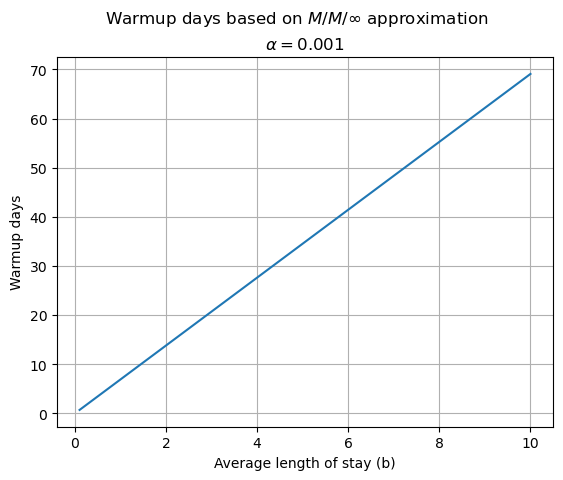

In [20]:
alpha = 0.001
b = np.linspace(start = 0.1, stop = 10.0)

t_star = -np.log(alpha) * b 

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_xlabel('Average length of stay (b)')
ax1.set_ylabel('Warmup days')
plt.title(r'$\alpha = 0.001$')
plt.suptitle(r'Warmup days based on $M/M/\infty$ approximation')
plt.grid(visible=True)

plt.plot(b, t_star);


### Horizon effects

Much like the warmup issue just described, if your stop data is based solely on departures during some date range, occupancy will be affected near the `end_analysis_dt` by those records with departure times after that date. Again, the way to avoid this is during the creation of the stop dataset by selecting records with departures after the `start_analysis_dt` AND arrivals before the `end_analysis_dt`. If that's not possible, then you can use the same warmup time adjustment (now it's a decay of occupancy) but subtract it from the last date for which you have departures in your data.